# Analysing the Cluster age function with Gaia DR2 data

We aim at a systematic reanalysis of the age distribution of Galactic open star clusters detected and characterised with [Gaia DR2](https://ui.adsabs.harvard.edu/abs/2018A%26A...616A...1G/abstract), thus improving on previous works relying on data from the pre-Gaia era, e.g. [Piskunov+2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...614A..22P/abstract) or [Krumholz+2019](https://ui.adsabs.harvard.edu/abs/2019ARA%26A..57..227K/abstract).

We first load some potentially useful modules:

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
import os.path
import matplotlib.gridspec as gridspec
from matplotlib import colors
from matplotlib.colors import LogNorm
from matplotlib import patches
from astropy.table import Table, Column, MaskedColumn
import seaborn as sns
import matplotlib
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from scipy.stats import gaussian_kde
from scipy import interpolate, stats
from scipy.optimize import minimize
from matplotlib import rcParams
rcParams['text.usetex'] = False
import pymc3
from multiprocessing import Pool # needed to speed up emcee fit

import emcee, corner
import abj2016, caf

Our base catalogue is the most recent complete catalogue of Gaia-DR2-proven clusters as of April 2020 ([Cantat-Gaudin+2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200407274C/abstract)).

For comparison, we also load the pre-Gaia MWSC data ([Kharchenko+2013](https://ui.adsabs.harvard.edu/abs/2013A%26A...558A..53K/abstract)) as well as the asterisms from [Schmeja+2014](https://ui.adsabs.harvard.edu/abs/2014A%26A...568A..51S/abstract) and [Scholz+2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...581A..39S/abstract) that were included in [Kharchenko+2016](https://ui.adsabs.harvard.edu/abs/2016A%26A...585A.101K/abstract) and [Piskunov+2018](https://ui.adsabs.harvard.edu/abs/2018A%26A...614A..22P/abstract), as well as the CAFs of previous works:

In [2]:
# Cantat-Gaudin+2020
nntable = Table.read("./data/Table1_CDS.fits")
for col in ["X", "Y", "Z", "Rgc"]:
    nntable[col] = nntable[col].astype(float)
mask = nntable["ageNN"]>0
nnfails = nntable[~mask ]
nntable = nntable[ mask ]
# estimate Bayesian parallax distances for the clusters not fitted by the ANN:
distpdf = abj2016.distpdf(nnfails["par"]+0.029, np.sqrt( nnfails["sigpar"]**2. + 0.05**2. ) )
nnfails["d"] = distpdf.modedist

nnfails["X"] = np.cos(nnfails["b"] * np.pi / 180.) * np.cos(nnfails["l"] * np.pi / 180.) * nnfails["d"]
nnfails["Y"] = np.cos(nnfails["b"] * np.pi / 180.) * np.sin(nnfails["l"] * np.pi / 180.) * nnfails["d"]
nnfails["Z"] = np.sin(nnfails["b"] * np.pi / 180.) * nnfails["d"]
nnfails["dxy"] = np.sqrt( nnfails["X"]**2. + nnfails["Y"]**2. ) / 1000.

# Pre-Gaia
kharchenko = Table.read("./data/Kharchenko2013.fits")
kharchenko["X"] = np.cos(kharchenko["GLAT"] * np.pi / 180.) * np.cos(kharchenko["GLON"] * np.pi / 180.) \
                  * kharchenko["d"]
kharchenko["Y"] = np.cos(kharchenko["GLAT"] * np.pi / 180.) * np.sin(kharchenko["GLON"] * np.pi / 180.) \
                  * kharchenko["d"]
schmeja    = Table.read("./data/Schmeja2014.fits")
scholz     = Table.read("./data/Scholz2015.fits")

# Get the manually extracted model points from Lamers et al. (2005), Fig. 10:
lamersa    = Table.read("./data/lamers2005_fig10a.csv")
lamersb    = Table.read("./data/lamers2005_fig10b.csv")
# & the CAFs computed by Piskunov et al. (2018), Fig. 4:
morales13  = Table.read("./data/Morales2013_CAF.csv")
piskunov06 = Table.read("./data/Piskunov2006_CAF.csv")
lamers05   = Table.read("./data/Lamers2005_CAF.csv")
pandey86   = Table.read("./data/PandeyMahra1986_CAF.csv")

## Comparison map: MWSC vs Gaia DR2

Plot an X-Y map of the OCs (pre- vs post-Gaia):

<IPython.core.display.Javascript object>


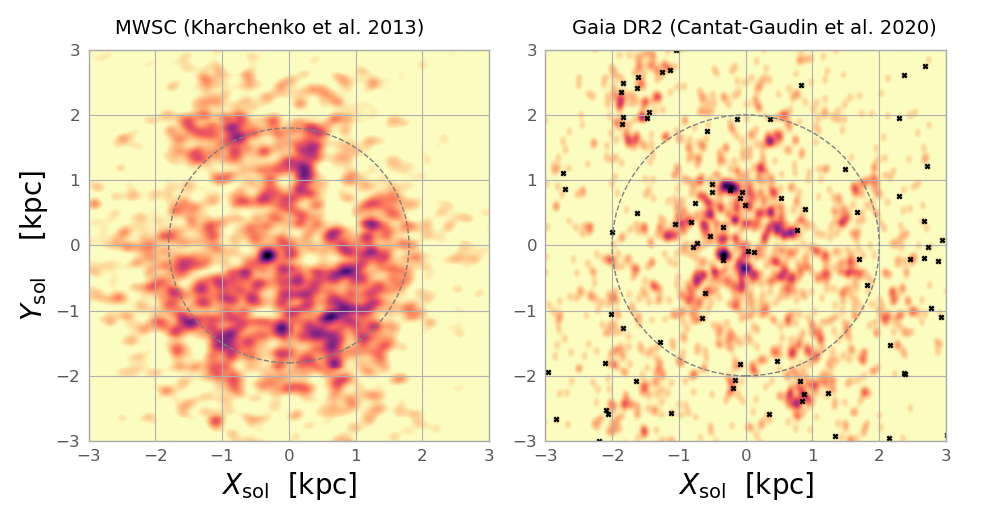

In [3]:
fig = plt.figure(figsize=(10., 5.2))

# Left: Kharchenko+2013, right: Cantat-Gaudin+2020
subplots = [121,122]
data = [ np.vstack([kharchenko["X"]/1000., kharchenko["Y"]/1000.]),
         np.vstack([nntable["X"]/1000., nntable["Y"]/1000.]) ]
text = ["MWSC (Kharchenko et al. 2013)", "Gaia DR2 (Cantat-Gaudin et al. 2020)"]
dcircle = [1.8, 2]

for ii in [0,1]:
    ax  = plt.subplot(subplots[ii])
    kde = gaussian_kde(data[ii], bw_method=0.025)

    xrange=(-3,3)
    yrange=(-3,3)
    grid=400
    # evaluate on a regular grid
    xgrid = np.linspace(xrange[0], xrange[1], grid)
    ygrid = np.linspace(yrange[0], yrange[1], grid)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    # Plot the result as an image
    plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[xrange[0], xrange[1],yrange[0], yrange[1]],
           cmap='magma_r', vmin=0.01)#,norm=LogNorm())

    plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
    ax.set_xlabel(r"$X_{\rm sol}$  [kpc]", fontsize=20)
    if ii == 0:
        ax.set_ylabel(r"$Y_{\rm sol}$    [kpc]", fontsize=20)
    else:
        ax.scatter(nnfails["X"], nnfails["Y"], marker="x", s=10, c="k")

    ax.text(-2.6,3.25, text[ii], fontsize=14)
    
    # Overplot the completeness limit commonly assumed for MWSC:
    circle1 = plt.Circle((0, 0), dcircle[ii], color='grey', ls="--", fill=False)
    ax.add_artist(circle1)
    
plt.tight_layout()
plt.savefig("./im/XYmap_clusters_mwsc_vs_gaia_3kpc.png", dpi=150)


## Get the completeness from the above plot & the cluster recovery experiment of Castro-Ginard+2020

When computing the completeness of the Gaia DR2 ANN cluster catalogue of [Cantat-Gaudin+2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200407274C/abstract) down to a limiting distance of $d_{xy}=2$ kpc, we take two effects into account:

1. Clusters missing from the census: We use the age-dependent recovery fraction determined from the cluster recovery experiment of [Castro-Ginard+2020](https://ui.adsabs.harvard.edu/abs/2020A%26A...635A..45C/abstract).
2. Clusters for which the neural network employed by [Cantat-Gaudin+2020](https://ui.adsabs.harvard.edu/abs/2020arXiv200407274C/abstract) was not able to find a solution (very few, typically sparse and/or very red objects)

We refer to the other notebook for details.

In [4]:
lgrid = np.linspace(0, 360, 5)
bgrid = np.linspace(-20,20, 3)
tgrid = np.linspace(6,10, 5)
dgrid = np.linspace(1,3,5)

selfrac = np.load("./data/castro-ginard-completeness-selfrac.npy")
# Integrating over the (l,b) dimension:
selfrac_2d = np.nansum(selfrac / 8, axis = (0,1))

def completeness_agebin_castroginard(logt, dmax=2):
    """
    Gets you an interpolated completeness value at for a given age value - inferred from the 
    the data behind Castro-Ginard+2020, Fig. 1.
    """
    if dmax==2:
        comp = (selfrac_2d[:,0] * np.pi*dgrid[0]**2. + selfrac_2d[:,1] * np.pi*(dgrid[1]**2.-dgrid[0]**2.) + \
               + selfrac_2d[:,2] * np.pi*(dgrid[2]**2.-dgrid[1]**2.) ) / (np.pi*dgrid[2]**2.)
    f = interpolate.interp1d(0.5*(tgrid[1:]+tgrid[:-1]), comp, kind="linear", fill_value=(comp[0],  comp[-1]), bounds_error=False)
    return f(logt)

def completeness_agebin_cantat2020_ann(logt, dmax=2.):
    """
    Gets you an interpolated completeness of the ANN catalogue compared to the full CG2020 - inferred from the 
    the Kharchenko+2013 ages for the clusters that lack ANN parameters
    """
    agebins = np.linspace(6,10,5)
    comp_nn = np.zeros(4)
    if dmax==2.:
        comp_nn = [0.7692, 0.9932, 0.9955 , 1.]
    f = interpolate.interp1d(0.5*(agebins[1:]+agebins[:-1]), comp_nn, kind="linear", 
                             fill_value=(comp_nn[0],  comp_nn[-1]), bounds_error=False)
    return f(logt)


def combined_completeness(logt, dmax=2.):
    """
    Gets you the completeness of the ANN catalogue of CG+2020 (taking into account 2 effects:
    1) Not all CG2020 OCs have ANN parameters derived
    2) The detection efficiency of the latest all-plane search of Castro-Ginard+2020
    """
    return completeness_agebin_castroginard(logt, dmax=dmax) * completeness_agebin_cantat2020_ann(logt, dmax=dmax)

print("Detection completeness for logage=[6,7,8,9,10] at 2kpc:", completeness_agebin_castroginard([6,7,8,9,10], dmax=2.))
print("ANN completeness for       logage=[6,7,8,9,10] at 2kpc:", completeness_agebin_cantat2020_ann([6,7,8,9,10], dmax=2.))
print("Combined completeness for  logage=[6,7,8,9,10] at 2kpc:", combined_completeness([6,7,8,9,10], dmax=2.))

Detection completeness for logage=[6,7,8,9,10] at 2kpc: [0.43847656 0.63128058 0.86378083 0.89884139 0.89420573]
ANN completeness for       logage=[6,7,8,9,10] at 2kpc: [0.7692  0.8812  0.99435 0.99775 1.     ]
Combined completeness for  logage=[6,7,8,9,10] at 2kpc: [0.33727617 0.55628445 0.85890047 0.896819   0.89420573]


Now we are ready to plot **Figure 1** (takes ~2min to plot):

<IPython.core.display.Javascript object>


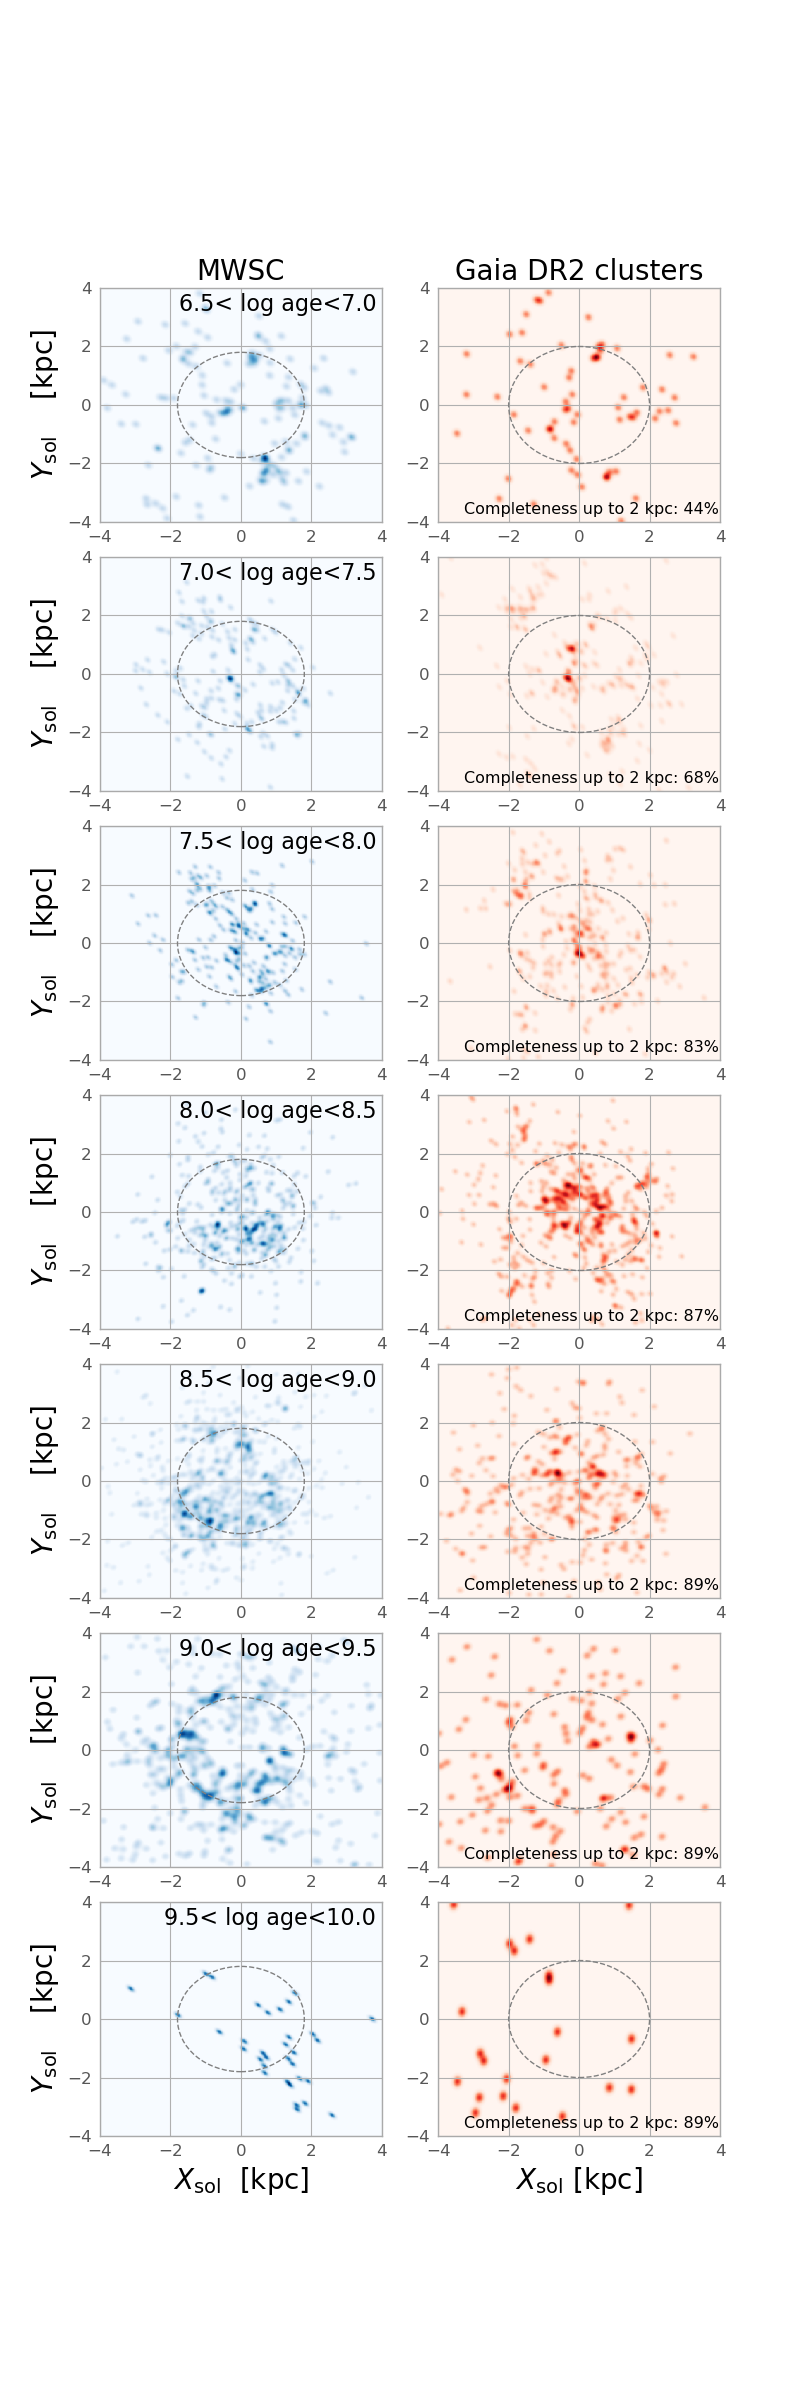

0
1
2
3
4
5
6


/home/friedel/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


In [5]:
k13_xy = np.vstack([kharchenko["X"]/1000., kharchenko["Y"]/1000.])
c20_xy = np.vstack([nntable["X"].filled()/1000., nntable["Y"].filled()/1000.])

plot_density = False

ages  = kharchenko["logt"]
dists = 0.001 *np.sqrt(kharchenko["X"]**2. + kharchenko["Y"]**2.)
ages2 = nntable["ageNN"]
dists2= 0.001 * np.sqrt(nntable["X"]**2. + nntable["Y"]**2.)
agebins = np.arange(6.5,10.1,0.5)

nbins = 25
dup   = 5.
distarr = np.linspace(0,dup,nbins+1) 
distarr2= (distarr[1:] + distarr[:-1]) / 2.
areaarr = -(distarr[:-1] - distarr[1:]) * 2. * np.pi * distarr2

dlimit  = 1.8
completeness = np.zeros(len(agebins)-1)

fig = plt.figure(figsize=(8, 24))
gs = gridspec.GridSpec(len(agebins)-1, 2, hspace=0.15)

for ii in np.arange(len(agebins)-1):
    print(ii)
    ax = plt.subplot(gs[ii*2])
    xrange=(-4,4)
    yrange=(-4,4)
    
    mask= (k13_xy[0,:] > xrange[0]) & (k13_xy[0,:] < xrange[1]) & (k13_xy[1,:] > yrange[0]) & (k13_xy[1,:] < yrange[1])
    kde = gaussian_kde(k13_xy[:,(ages > agebins[ii]) & (ages < agebins[ii+1]) & mask], bw_method=0.05)

    grid=400
    # evaluate on a regular grid
    xgrid = np.linspace(xrange[0], xrange[1], grid)
    ygrid = np.linspace(yrange[0], yrange[1], grid)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    # Plot the result as an image
    plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[xrange[0], xrange[1],yrange[0], yrange[1]],
           cmap='Blues', vmin=0.01)#,norm=LogNorm())

    plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
    if ii == 6:
        ax.set_xlabel(r"$X_{\rm sol}$  [kpc]", fontsize=20)
    ax.set_ylabel(r"$Y_{\rm sol}$    [kpc]", fontsize=20)
    ax.set_yticks([-4,-2,0,2,4])
    if ii ==0:
        plt.title(r"MWSC", fontsize=20)
    
    # Overplot the completeness limit commonly assumed for MWSC:
    circle1 = plt.Circle((0, 0), 1.8, color='grey', ls="--", fill=False)
    ax.add_artist(circle1)
    ax.text(.98, .98, str(agebins[ii])+"< log age<"+str(agebins[ii+1]), transform=ax.transAxes,
            va="top", ha="right", fontsize=16)
    ####
    ax = plt.subplot(gs[ii*2+1])
    
    mask= (c20_xy[0,:] > xrange[0]) & (c20_xy[0,:] < xrange[1]) & (c20_xy[1,:] > yrange[0]) & (c20_xy[1,:] < yrange[1])
    kde = gaussian_kde(c20_xy[:,(ages2 > agebins[ii]) & (ages2 < agebins[ii+1]) & mask], bw_method=0.05)

    # evaluate on a regular grid
    xgrid = np.linspace(xrange[0], xrange[1], grid)
    ygrid = np.linspace(yrange[0], yrange[1], grid)
    Xgrid, Ygrid = np.meshgrid(xgrid, ygrid)
    Z = kde.evaluate(np.vstack([Xgrid.ravel(), Ygrid.ravel()]))

    # Plot the result as an image
    plt.imshow(Z.reshape(Xgrid.shape),
           origin='lower', aspect='auto',
           extent=[xrange[0], xrange[1],yrange[0], yrange[1]],
           cmap='Reds', vmin=0.01)#,norm=LogNorm())

    plt.axis([xrange[0], xrange[1], yrange[0], yrange[1]])
    if ii ==0:
        plt.title(r"Gaia DR2 clusters", fontsize=20)
    ax.set_yticks([-4,-2,0,2,4])
    
    # Overplot the completeness limits obtained from the analysis below:)
    circle1 = plt.Circle((0, 0), 2., color='grey', ls="--", fill=False)
    ax.add_artist(circle1)
    comp_ii = combined_completeness(0.5*(agebins[ii]+agebins[ii+1]), dmax=2.)
    ax.text(0.995, .02,"Completeness up to 2 kpc: "+str(np.int(100 * comp_ii))+"%", 
                transform=ax.transAxes,va="bottom", ha="right", fontsize=11.5)
    if ii > 5:
        ax.set_xlabel(r"$X_{\rm sol}$ [kpc]", fontsize=20)
    else:
        ax.set_xlabel("")
    
plt.tight_layout()
plt.savefig("./im/XYmap_clusters_mwsc_vs_gaia_4kpc_agebins_new.png", dpi=150)


## Open cluster ages

Let's first look naively at the age distribution for clusters within 1.8 kpc (as in Joshii+2016 or Piskunov+2018): this is **Figure 2, top panel**.

<IPython.core.display.Javascript object>


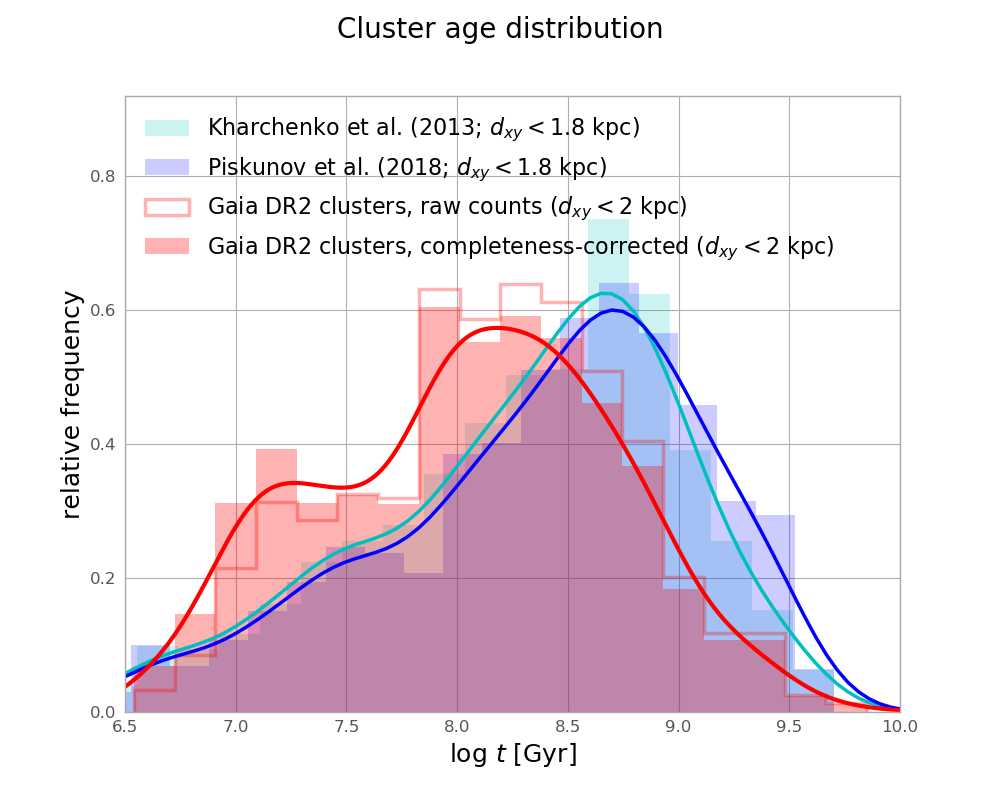

In [6]:
fig = plt.figure(figsize=(10, 8))
axi = plt.subplot(111)

dmax = 2.0

# To cross-check with Piskunov+2018, concatenate the ages from the 3 MWSC papers:
ages_mwsc = np.hstack([kharchenko["logt"][kharchenko["d"]<1800.],
                      schmeja["logt"][schmeja["d"]<1800.],
                      scholz["logt"][scholz["d"]<1800.] ])

sns.distplot(kharchenko["logt"][kharchenko["d"]<1800.], 
             rug=False, rug_kws={"color": "c"}, kde_kws={"color": "c", "lw": 2.5},
             hist_kws={"alpha": .2, "color": "c"}, label="Kharchenko et al. (2013; $d_{xy} < 1.8$ kpc)")
sns.distplot(ages_mwsc, 
             rug=False, rug_kws={"color": "b"}, kde_kws={"color": "b", "lw": 2.5},
             hist_kws={"alpha": .2, "color": "b"}, label="Piskunov et al. (2018; $d_{xy} < 1.8$ kpc)")

# Add completeness-corrected histogram
agevals  = nntable["ageNN"].filled()[dists2<dmax]
vals, bins, patches = plt.hist(agevals, density=True, histtype="step", bins="fd", lw=2.5,
                               label="Gaia DR2 clusters, raw counts ($d_{xy} < 2$ kpc)", alpha=.3, color="r")
plt.hist(agevals, density=True, weights=1./combined_completeness(agevals, dmax=dmax), histtype="stepfilled", bins=bins,
         label="Gaia DR2 clusters, completeness-corrected ($d_{xy} < 2$ kpc)", alpha=.3, color="r")
kde = gaussian_kde(agevals, weights=1./combined_completeness(agevals), bw_method="scott")
kdearr = np.linspace(6,10,1000)
plt.plot(kdearr, kde.evaluate(kdearr), c="r", lw=3)

plt.axis([6.5,10.,0,0.92])
axi.set_xlabel(r"log $t$ [Gyr]", fontsize=18)
axi.set_ylabel(r"relative frequency", fontsize=18)

# Overplot the completeness as shadow:
plt.legend(fontsize=16, framealpha=0, loc="upper left")
plt.suptitle("Cluster age distribution", fontsize=20)
plt.savefig("./im/age-distribution_mwsc_vs_gaia_"+str(dmax)+"kpc.png", dpi=150)
plt.show()

## Cluster age function

We try to reproduce Fig. 7 of Krumholz+2019 (or equivalently, Fig. 3 of Piskunov+2018). 
First we define a function to compute the Cluster Age function (following the formulae in Sect. 3.2 in Piskunov+2018):

In [7]:
def CAF(ages, logtmin=6., logtmax=10.1, dlogt=0.2, weights=None, bins=None, dlim=2.):
    """
    Cluster age function, as defined in Piskunov et al. (2018, Sect. 3.2).
    
    Input:
        ages: array of measured ages
    Optional:
        logtmin, logtmax, dlogt: edges and bin size of the cluster age function
        weights: if None: assume that the selection function does not depend on age.
                 if array: pass weight of each datapoint
        
    Output:
        agearray: agebin midpoints
        logeta:   log10(CAF) value in the respective bin
        e_logeta_p, e_logeta_m : +-uncertainties of the log10(CAF) value in the respective bin
    """
    ages = np.array(ages) # workaround for astropy arrays
    if bins==None:
        agebins = np.arange(logtmin, logtmax, dlogt)
    else:
        agebins = bins
    agearray = (agebins[1:]+agebins[:-1])/2.
    N_k    = np.zeros(len(agebins)-1)
    logt_k = np.zeros(len(agebins)-1)

    for ii in np.arange(len(N_k)):
        # count the number of clusters in each bin
        if weights is None:
            N_k[ii] = len( ages[(ages>agebins[ii]) & (ages<agebins[ii+1])])
        else:
            N_k[ii] = np.sum(weights[(ages>agebins[ii]) & (ages<agebins[ii+1])])
        logt_k[ii]=agebins[ii+1]-agebins[ii]
    
    # Follow the formulae in Piskunov+2018 to get eta(t)
    S0       = np.pi * dlim**2. # area covered
    logeta   = np.log10( np.log10(np.exp(1)) * N_k / (10.**(agearray) * logt_k * S0) ) 
    # Asymmetric uncertainties:
    e_logeta_p = np.log10( np.log10(np.exp(1)) * (N_k+np.sqrt(N_k)) / (10.**(agearray) * logt_k * S0) ) - logeta
    e_logeta_m = logeta - np.log10( np.log10(np.exp(1)) * (N_k-np.sqrt(N_k)) / (10.**(agearray) * logt_k * S0) ) 
    
    return agearray, logeta + 6, e_logeta_p, e_logeta_m # deliver in units of number per Myr per kpc²

The next plot is **Figure 2, middle panel**.

<IPython.core.display.Javascript object>


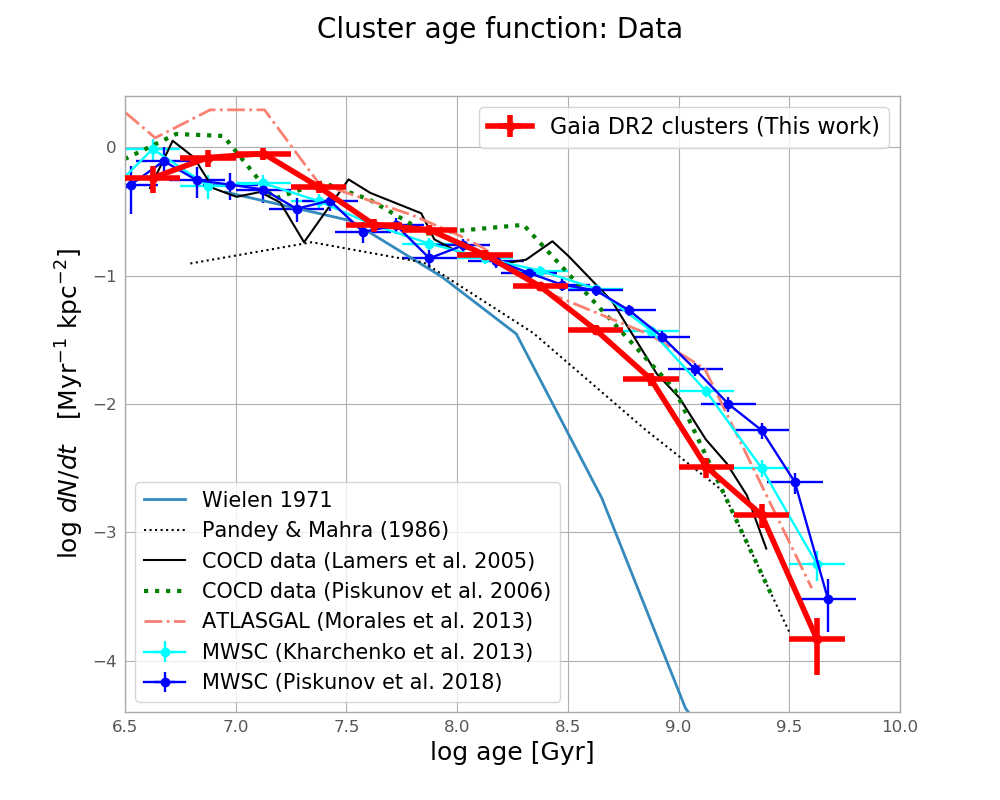

In [8]:
dmax=2.

# Compute the CAF for the 3 samples
aarr,  caf_k13,  e_caf_k13p,  e_caf_k13m   = CAF(kharchenko["logt"][kharchenko["d"]<1800.], logtmin=6., dlogt=0.25,
                                                 dlim=1.8)
aarr1, caf_mwsc, e_caf_mwscp, e_caf_mwscm  = CAF(ages_mwsc, logtmin=6., dlogt=0.15, dlim=1.8)
# For CG2020: Only take the age bins between 7 & 9.75 (i.e. the ones where we have complete data):
aarr2, caf_nn,   e_caf_nnp,   e_caf_nnm    = CAF(agevals, weights=1./combined_completeness(agevals, dmax=dmax), 
                                                 logtmin=6.5, logtmax=9.9, dlogt=0.25, dlim=dmax)
e_caf_nn = 0.5*(e_caf_nnp-e_caf_nnm)

# Wielen 1971 Table 1
agew = np.log10(np.array([0.09, .33, .85, 1.85, 4.5, 10.75, 57.5]) * 10.**8)
binsw= np.log10(np.array([0.001, .17, .5, 1.2, 2.5, 6.5, 15, 100]) * 10.**8)
logtw= binsw[1:]-binsw[:-1]
Nw   =          np.array([65,   30,   23, 15,   2.5, .12,  .035])
logetaw   = 6 + np.log10( np.log10(np.exp(1)) * Nw / (10.**(agew) * logtw * np.pi) ) 

fig = plt.figure(figsize=(10, 8))
axi = plt.subplot(111)

plt.errorbar(aarr, caf_k13, c="cyan", yerr=[e_caf_k13m,e_caf_k13p], label="MWSC (Kharchenko et al. 2013)",
             xerr=0.125, marker='o', ecolor=None, elinewidth=None, capsize=None)
plt.errorbar(aarr1, caf_mwsc, c="b", yerr=[e_caf_mwscm,e_caf_mwscp], label="MWSC (Piskunov et al. 2018)", 
             xerr=0.125, marker='o', ecolor=None, elinewidth=None, capsize=None)

plt.plot(agew, logetaw, lw=2, label="Wielen 1971")
p1986, = plt.plot(pandey86["logage"], pandey86["CAF"], lw=1.5,
                     c="k", ls="dotted", label="Pandey & Mahra (1986)")
l2005, = plt.plot(lamers05["logage"], lamers05["CAF"], lw=1.5,
                     c="k", ls="-", label="COCD data (Lamers et al. 2005)")
p2006, = plt.plot(piskunov06["logage"], piskunov06["CAF"], lw=3,
                     c="green", ls="dotted", label="COCD data (Piskunov et al. 2006)")
m2013, = plt.plot(morales13["logage"], morales13["CAF"], lw=2,
                     c="salmon", ls="-.", label="ATLASGAL (Morales et al. 2013)")
# Add the legend manually to the current Axes.
first_legend = plt.legend(loc="lower left", fontsize=15)
ax = plt.gca().add_artist(first_legend)

gdr2 = plt.errorbar(aarr2, caf_nn, c="r", yerr=[e_caf_nnm,e_caf_nnp], label="Gaia DR2 clusters (This work)", 
                     lw=4, xerr=.125, marker='o', ecolor=None, elinewidth=None, capsize=None, zorder=100)
plt.legend(loc="upper right", fontsize=16, handles=[gdr2])

plt.axis([6.5,10,-4.4,.4])
axi.set_xlabel(r"log age [Gyr]", fontsize=18)
axi.set_ylabel(r"log $dN/dt\quad [{\rm Myr}^{-1}\ {\rm kpc}^{-2}]$", fontsize=18)
plt.suptitle("Cluster age function: Data", fontsize=20)
plt.savefig("./im/caf_gaia_vs_literature.png", dpi=150)
plt.show()

## Fitting the CAF

Loosely following the recommendations of [Foreman-Mackey](https://emcee.readthedocs.io/en/stable/tutorials/line/) on the use of `emcee` for regression, we fit the binned CAF data.

First we define a set of convenient functions.

In [9]:
# Define the "okay-fit" models from Krumholz+2019, Fig. 7
def logbrokenpowerlaw(t, logfactor, alpha1, alpha2, tbreak):
    return np.piecewise(t, [t < tbreak, t >= tbreak], 
                        [lambda t: logfactor + t*alpha1, 
                         lambda t: logfactor + tbreak*(alpha1) + (t-tbreak)*alpha2 ])
def logschechterlaw(t, logfactor, alphaT, logtstar):
    return logfactor + t*alphaT - 10.**t/(10**logtstar)

# Define the likelihood, prior, and posterior:
def log_likelihood(theta, agebin, n_cl, e_n_cl, mod="schechter"):
    """
    Likelihood following the emcee tutorial. 
    Approximating the uncertainties in N_clusters per bin to be ~Gaussian
    
    Input:
        theta:  tuple/list of model parameters (including a nuisance parameter log_f)
        agebin: array of agebins
        n_cl:   array of number of clusters in each agebin
        e_n_cl: array of uncertainties associated to n_cl
    Output:
        Log likelihood
    """
    if mod == "schechter":
        logfactor, alphaT, taustar, log_f = theta
        model  = logschechterlaw(agebin, logfactor, alphaT, taustar)
    elif mod == "brokenpower":
        logfactor, alpha1, alpha2, taubreak, log_f = theta
        model  = logbrokenpowerlaw(agebin, logfactor, alpha1, alpha2, taubreak)
    sigma2 = e_n_cl ** 2 + np.exp(2 * log_f)
    return -0.5 * np.sum((n_cl - model) ** 2 / sigma2 + np.log(sigma2))

def log_prior(theta, mod="schechter"):
    if mod == "schechter":
        logfactor, alphaT, taustar, log_f = theta
        if 0 < logfactor < 9 and -1.5 < alphaT < -.3 and 8. < taustar < 9.5 and -6.0 < log_f < -0.7:
            return 0.0
        return -np.inf
    elif mod == "brokenpower":
        logfactor, alpha1, alpha2, taubreak, log_f = theta
        if 0 < logfactor < 9 and -1. < alpha1 < 0 and -4 < alpha2 < -1 and \
           7.8 < taubreak < 10.: #and -10.0 < log_f < 0.0:
            return 0.0
        return -np.inf

def log_probability(theta, agebin, n_cl, e_n_cl, **args):
    lp = log_prior(theta, **args)
    ll = log_likelihood(theta, agebin, n_cl, e_n_cl, **args)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ll 

Now run the emcee fitter for each of the models (Schechter law, broken powerlaw) considered:

In [10]:
agemin = 6.5

nll = lambda *args: -log_likelihood(*args)
guess = [3, -1., 9., -3.]
initial = np.array(guess) + 0.05 * np.random.randn(4)
soln = minimize(nll, initial, args=(aarr2, caf_nn, e_caf_nn))
f_ml, a_ml, t_ml, log_f_ml = soln.x

nll2 = lambda *args: -log_likelihood(*args, mod = "brokenpower")
guess2 = [4, -0.6, -1.8, 8.8, -2.]
initial2 = np.array(guess2) + 0.05 * np.random.randn(5)
soln2 = minimize(nll2, initial2, args=(aarr2, caf_nn, e_caf_nn))
f_ml2, a1_ml2, a2_ml2, t_ml2, log_f_ml2 = soln2.x

pos = guess + 1.e-4 * np.random.randn(64, 4)
nwalkers, ndim = pos.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aarr2[aarr2>agemin], caf_nn[aarr2>agemin], e_caf_nn[aarr2>agemin]))
sampler.run_mcmc(pos, 10000, progress=True);

pos2 = guess2 + 1.e-4 * np.random.randn(64, 5)
nwalkers2, ndim2 = pos2.shape
sampler2 = emcee.EnsembleSampler(nwalkers2, ndim2, log_probability, args=(aarr2[aarr2>agemin], caf_nn[aarr2>agemin], e_caf_nn[aarr2>agemin]), 
                                 kwargs={"mod":"brokenpower"})
sampler2.run_mcmc(pos2, 10000, progress=True);


100%|██████████| 10000/10000 [00:30<00:00, 330.87it/s]


<IPython.core.display.Javascript object>


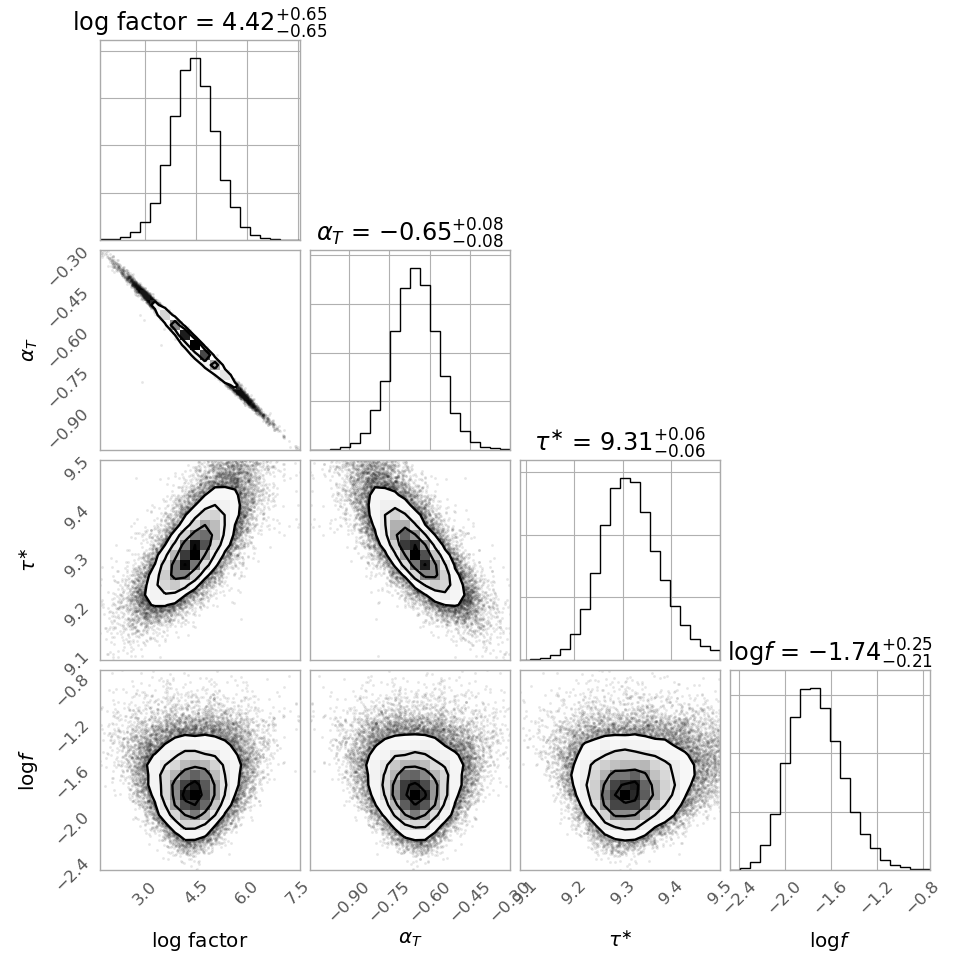

In [11]:
flat_samples  = sampler.get_chain(discard=100, thin=15, flat=True)
labels = ["$\log$ factor", r"$\alpha_T$", r"$\tau^{\ast}$", r"$\log f$"]
fig = corner.corner(flat_samples[:,:], labels=labels, show_titles=True)

<IPython.core.display.Javascript object>


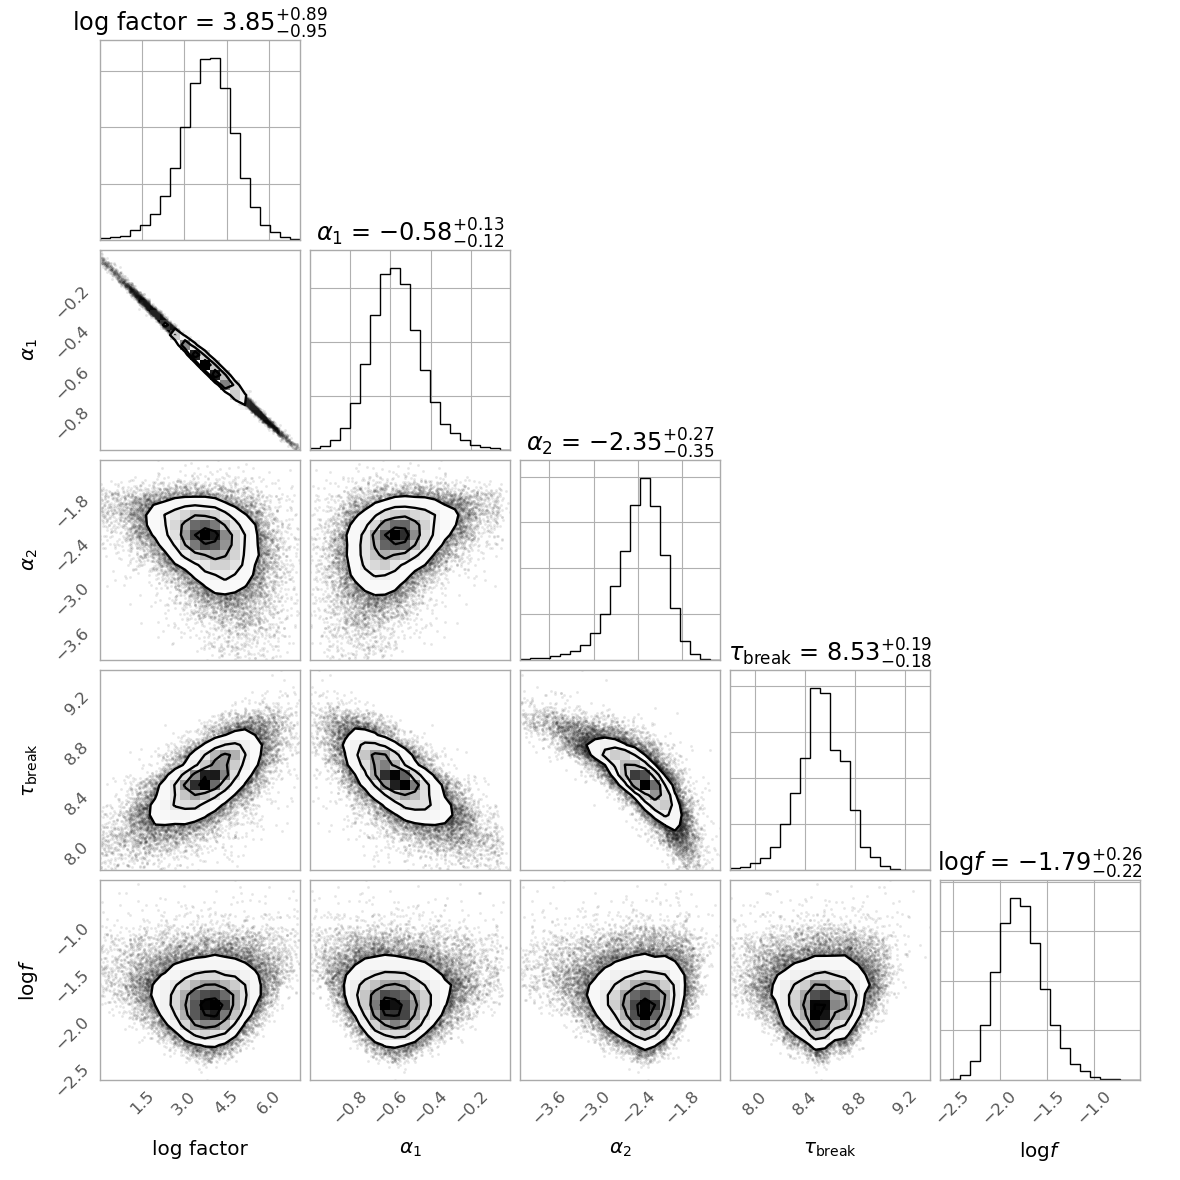

In [12]:
flat_samples2 = sampler2.get_chain(discard=100, thin=15, flat=True)
labels2 = ["log factor", r"$\alpha_1$", r"$\alpha_2$", r"$\tau_{\rm break}$", r"$\log f$"]
fig = corner.corner(flat_samples2[:,:], labels=labels2, show_titles=True)

And now we are ready to plot **Figure 2, bottom panel**.

<IPython.core.display.Javascript object>


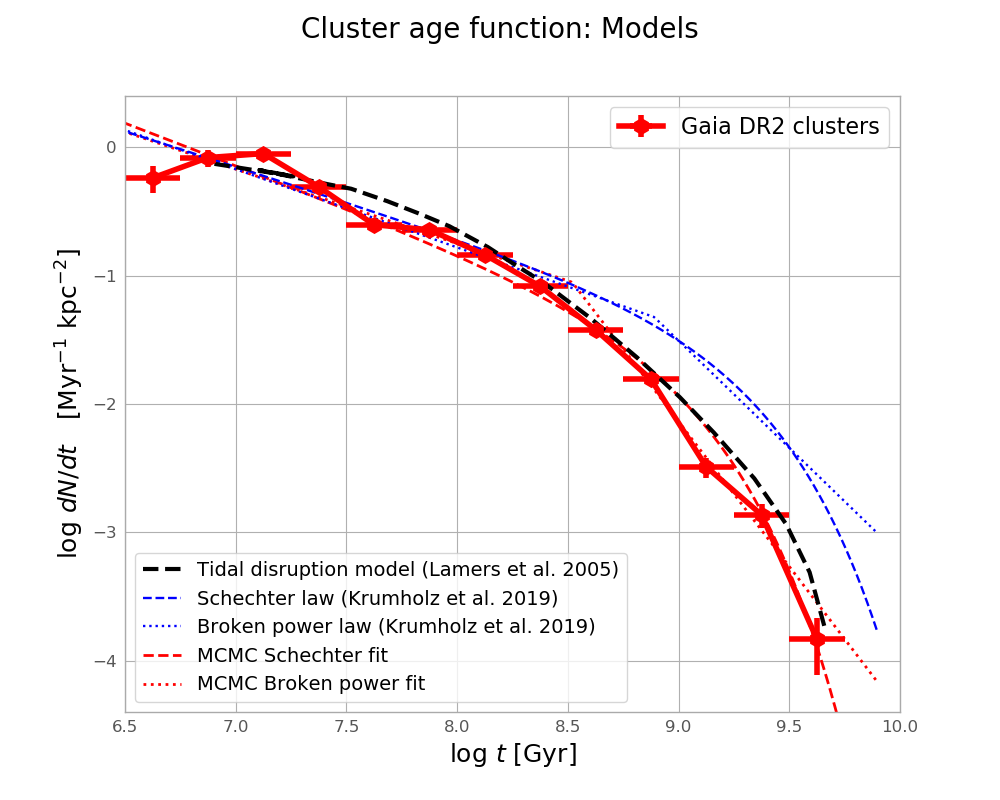

$\log$ factor : 4.48 1sigma HDR: [3.8  5.09]
$\alpha_T$ : -0.66 1sigma HDR: [-0.74 -0.57]
$\tau^{\ast}$ : 9.32 1sigma HDR: [9.25 9.37]
$\log f$ : -1.79 1sigma HDR: [-1.97 -1.51]
log factor : 3.89 1sigma HDR: [2.98 4.81]
$\alpha_1$ : -0.58 1sigma HDR: [-0.71 -0.47]
$\alpha_2$ : -2.26 1sigma HDR: [-2.62 -2.02]
$\tau_{\rm break}$ : 8.52 1sigma HDR: [8.39 8.75]
$\log f$ : -1.77 1sigma HDR: [-2.03 -1.55]


In [16]:
fig = plt.figure(figsize=(10, 8))
axi = plt.subplot(111)

plot_k19  = True

bestvals,  bestvals2  = [], []
bestvalsu, bestvals2u = [], []
bestvalsl, bestvals2l = [], []

for i in range(ndim):
    # Get the mode statistics for each parameter
    mcmc = stats.mode(np.round(flat_samples[:, i],2), axis=None)[0][0]
    q = np.round(pymc3.stats.hpd(flat_samples[:, i], alpha=.32), 2)
    print(labels[i], ":", mcmc, "1sigma HDR:", q)
    bestvals.append(mcmc); bestvalsl.append(mcmc-q[0]); bestvalsu.append(mcmc+q[1])
for i in range(ndim2):
    # Get the mode statistics for each parameter
    mcmc2 = stats.mode(np.round(flat_samples2[:, i],2), axis=None)[0][0]
    q = np.round(pymc3.stats.hpd(flat_samples2[:, i], alpha=.32), 2)
    print(labels2[i], ":", mcmc2, "1sigma HDR:", q)
    bestvals2.append(mcmc2); bestvals2l.append(mcmc2-q[0]); bestvals2u.append(mcmc2+q[1])

plt.errorbar(aarr2, caf_nn, c="r", yerr=[e_caf_nnm,e_caf_nnp], label="Gaia DR2 clusters", lw=4, mew=2,
             xerr=0.125, marker='h', markerfacecolor="r", ecolor="r", elinewidth=None, capsize=None, markersize=10)

# Add the legend manually to the current Axes.
first_legend = plt.legend(loc="upper right", fontsize=16)
ax = plt.gca().add_artist(first_legend)

tarr = np.linspace(6.3,9.9,300)

mcs,   = plt.plot(tarr, logschechterlaw(tarr, bestvals[0], bestvals[1], bestvals[2]),
                     c="r", ls="--", lw=2, label='MCMC Schechter fit')#:\n $\\alpha_T={:4.2f}$, $\\log\\,T_*={:4.2f}$'.format(bestvals[1], bestvals[2]))
mcb,   = plt.plot(tarr, logbrokenpowerlaw(tarr, bestvals2[0], bestvals2[1], bestvals2[2], bestvals2[3]),
                  c="r", ls="dotted", lw=2, label='MCMC Broken power fit')#:\n $\\alpha_1={:4.2f}, \\alpha_2={:4.2f}$, $\\log\\,T_b={:4.2f}$'.format(bestvals2[1], bestvals2[2], bestvals2[3]))
if plot_k19:
    schechter,= plt.plot(tarr, 3.3+logschechterlaw(tarr, 4.e-1, -0.55, 9.59), 
                         c="b", ls="--", label="Schechter law (Krumholz et al. 2019)")
    brokenpow,= plt.plot(tarr, 3+logbrokenpowerlaw(tarr, 1.1e0, -.61, -1.67, 8.89), 
                         c="b", ls="dotted", label="Broken power law (Krumholz et al. 2019)")
l2005a, = plt.plot(lamersa["logage"], lamersa["CAF"]+6, lw=3,
                     c="k", ls="--", label="Tidal disruption model (Lamers et al. 2005)")

#l2005b,=plt.plot(tarr, lamers2005burst2(tarr, 7, 3.6, 4, 5, 6.8, 7.3), color="k", ls="-.", lw=2,
#         label=r"Lamers+2005 type model with burst")

plt.legend(loc="lower left", fontsize=14, handles=[l2005a, schechter, brokenpow, mcs, mcb]) # , l2005b])
plt.axis([6.5,10,-4.4,.4])

axi.set_xlabel(r"log $t$ [Gyr]", fontsize=18)
axi.set_ylabel(r"log $dN/dt\quad [{\rm Myr}^{-1}\ {\rm kpc}^{-2}]$", fontsize=18)
plt.suptitle("Cluster age function: Models", fontsize=20)
plt.savefig("./im/caf_mwsc_vs_gaia_2kpc_models.png", dpi=150)
plt.show()